In [1]:
import tensorflow as tf
import PIL.Image
import numpy as np
import glob
from FCDenseNet import FCDenseNet
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
classes = [
    tf.constant([0, 255, 255], dtype=tf.uint8), # urban_land
    tf.constant([255, 255, 0], dtype=tf.uint8), # agriculture_land
    tf.constant([255, 0, 255], dtype=tf.uint8), # rangeland
    tf.constant([0, 255, 0], dtype=tf.uint8), # forest_land
    tf.constant([0, 0, 255], dtype=tf.uint8), # water
    tf.constant([255, 255, 255], dtype=tf.uint8), # barren_land
    tf.constant([0, 0, 0], dtype=tf.uint8), # unknown
]

# class DiceBCELoss(tf.keras.losses.Loss):
#     def decode_mask(self, mask_image):
#         colour_codes = np.array(classes)
#         _mask_image = tf.identity(mask_image).numpy().astype(int)
#         return colour_codes[_mask_image]

#     def call(self, y_true, y_pred):
#         y_true = self.decode_mask(y_true)
#         h, w, c = y_true.shape[1:]
#         smooth = 1e-5
#         pred_flat = tf.reshape(y_pred, [-1, h * w * c])
#         true_flat = tf.reshape(y_true, [-1, h * w * c])
#         intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + smooth
#         denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(true_flat, axis=1) + smooth
#         loss = 1 - tf.reduce_mean(intersection / denominator)
        
#         return loss

In [4]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1,
    decay_rate=0.995
)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
)
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    './checkpoints/',
    save_best_only=True,
    save_weights_only=False,
)
tensorboard = tf.keras.callbacks.TensorBoard(
    './logs',
    write_graph=True,
    write_images=True,
)

In [5]:
model = FCDenseNet([4, 4, 4, 4, 4], 5, 12, 48, 7) # FC-DenseNet57
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    run_eagerly=True
)
model.load_weights('../serving_model/FC-DenseNet57_houses')

In [6]:
def decode_tfrecord(record):
    return tf.io.parse_single_example(
        record,
        {
            'sat_image': tf.io.FixedLenFeature([], dtype=tf.string),
            'mask_image': tf.io.FixedLenFeature([], dtype=tf.string),
        }
    )

def preprocess_data(sample):
    sat_image = tf.image.decode_image(sample['sat_image'], channels=3)
    mask_image = tf.image.decode_image(sample['mask_image'], channels=3)
    tf.Tensor.set_shape(sat_image, (320, 320, 3))
    tf.Tensor.set_shape(mask_image, (320, 320, 3))

    mask_layer = tf.zeros((320, 320), dtype=tf.uint8)
    for idx, class_color in enumerate(classes):
        _mask = mask_image == class_color
        _mask = tf.reduce_all(_mask, axis=2)
        _mask = tf.where(_mask, idx, 0)
        _mask = tf.cast(_mask, tf.uint8)
        mask_layer = mask_layer + _mask
    
    sat_image = tf.cast(sat_image, tf.float32)
    return sat_image, mask_layer
    
def get_dataset(pattern, tfr_dir):
    files = glob.glob(tfr_dir + pattern, recursive=False)
    dataset = tf.data.TFRecordDataset(files)

    autotune = tf.data.AUTOTUNE
    dataset = dataset.map(decode_tfrecord, num_parallel_calls=autotune)
    dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
    dataset = dataset.shuffle(16)
    dataset = dataset.batch(3, drop_remainder=True)
    dataset = dataset.prefetch(autotune)

    return dataset

In [8]:
train_dataset = get_dataset('*land.tfrecord', './data/dataset/content/train/')
valid_dataset = get_dataset('*land.tfrecord', './data/dataset/content/valid/')
test_dataset = get_dataset('*land.tfrecord', './data/dataset/content/test/')

In [11]:
history = model.fit(train_dataset,
    validation_data=valid_dataset,
    epochs=50, verbose=1,
    callbacks=[early_stopping, checkpointer, tensorboard]
)

Epoch 1/50
   1100/Unknown - 501s 450ms/step - loss: 1.1373INFO:tensorflow:Assets written to: ./checkpoints/assets
1100/1100 [==============================] - 572s 514ms/step - loss: 1.1373 - val_loss: 1.4105
Epoch 2/50
1100/1100 [==============================] - 544s 495ms/step - loss: 1.1266 - val_loss: 1.4654
Epoch 3/50
1100/1100 [==============================] - 545s 495ms/step - loss: 1.1038 - val_loss: 1.4950
Epoch 4/50
1100/1100 [==============================] - 565s 513ms/step - loss: 1.1038 - val_loss: 1.3430
Epoch 5/50
1100/1100 [==============================] - 541s 491ms/step - loss: 1.0742 - val_loss: 1.3616
Epoch 6/50
1100/1100 [==============================] - 542s 492ms/step - loss: 1.0590 - val_loss: 1.5001
Epoch 7/50
1100/1100 [==============================] - 543s 493ms/step - loss: 1.0478 - val_loss: 1.6826
Epoch 8/50
1100/1100 [==============================] - 539s 490ms/step - loss: 1.0411 - val_loss: 1.4918
Epoch 9/50
1100/1100 [==========================

In [12]:
# model.save_weights('../serving_model/FC-DenseNet57_19epochs')

In [ ]:
# Urban land - cyan
# Agriculture land - amarillo
# Rangeland - lila
# Forest land - green
# Water - azul
# Barren land - blanco
# Unknown - negro

def decode_mask(mask_image):
    colour_codes = np.array(classes)
    return colour_codes[mask_image.astype(int)]

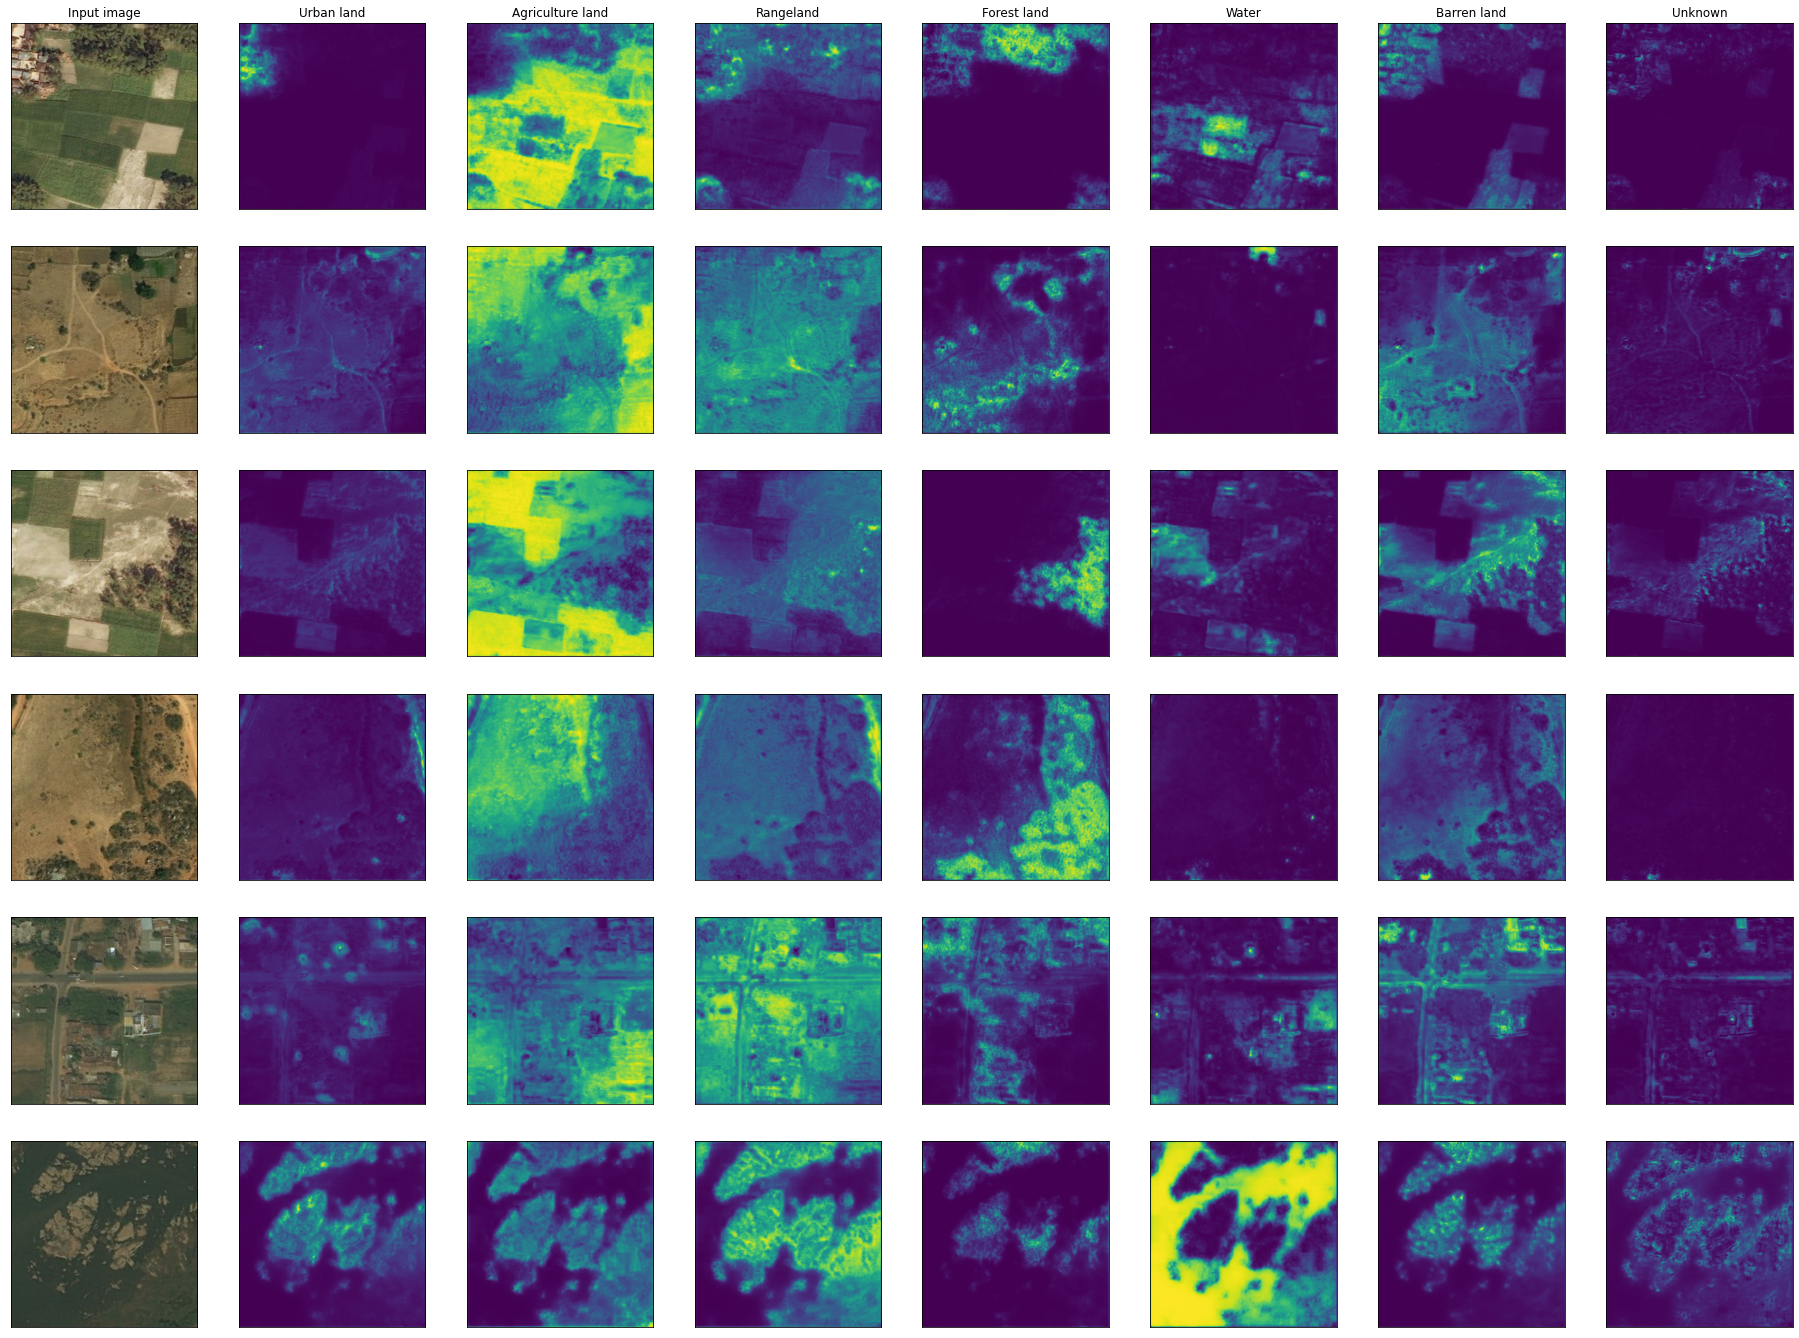

In [23]:
sat_imgs = []
mask_imgs = []
pred_imgs = []
for sat, mask in test_dataset.shuffle(256).take(2):
    pred = model(sat)
    sat_imgs.append(sat.numpy())
    mask_imgs.append(mask.numpy())
    pred_imgs.append(pred.numpy())
sat_imgs = np.concatenate(sat_imgs, axis=0)
mask_imgs = np.concatenate(mask_imgs, axis=0)
pred_imgs = np.concatenate(pred_imgs, axis=0)
tot_imgs = sat_imgs.shape[0]

land_names = ['Urban land', 'Agriculture land', 'Rangeland', 'Forest land', 'Water', 'Barren land', 'Unknown',]
plt.figure(figsize=(32, 4 * tot_imgs))
for i in range(tot_imgs):
    ax = plt.subplot(tot_imgs, 8, 8 * i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_gid(False)
    ax.imshow(sat_imgs[i].astype(np.uint8))
    if i == 0:
        ax.set_title('Input image')
    for j in range(7):
        ax = plt.subplot(tot_imgs, 8, 8 * i + 2 + j)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_gid(False)
        ax.imshow(pred_imgs[i, :, :, j])
        if i == 0:
            ax.set_title(land_names[j])